# Práctico 6 - Procesamiento Digital de Imágenes

In [132]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import canny

%matplotlib inline

In [133]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

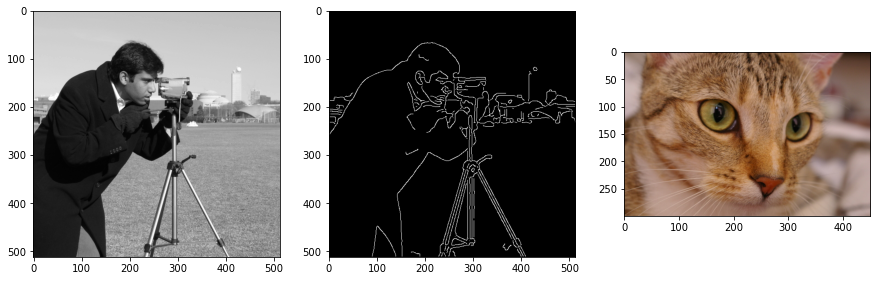

In [134]:
img_gray = imageio.imread('imageio:camera.png')/255
img_rgb = imageio.imread('imageio:chelsea.png')/255
# img_bin = canny(rgb2yiq(img_rgb)[:,:,0], sigma=2)
img_bin = canny(img_gray, sigma=2)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_bin, 'gray')
axes[2].imshow(img_rgb)

# Operaciones morfológicas

Implementar funciones que devuelvan los siguientes structuring elements. Son similares a un kernel convolucional pero el tipo de dato es booleano (True o False). Incluso pueden construirse aplicando un threshold a un kernel. Ej: se_box = kernel_box > 0

1. Box
2. Circle

Utilizando las funciones de ejemplo implementar las siguientes operaciones morfológicas, tanto para escala de grises como para RGB. Para RGB realizar la operación en base a los valores del canal Y:

Operaciones básicas (nivel 1):

1. Dilatación
2. Erosión
3. Filtro de mediana

Operaciones de suma/resta entre erosión y dilatación:

4. Borde externo
5. Borde interno
6. Gradiente

Operaciones concatenando dilatación y erosión (nivel 2):

7. Apertura (opening)
8. Cierre (closing)
9. Top-hat
10. Bottom-hat

Operaciones concatenando cierre y apertura (nivel 3):

11. OC
12. CO

Funciones útiles a partir de operaciones morfológicas:

13. Suavizado. Puede calcularse como el promedio entre operaciones del mismo nivel. Ej: (dilatación + erosión)/2  o  (apertura + cierre)/2. Los parámetros de entrada deben ser la imagen, el structuring element y el nivel deseado.
14. Realce de contraste (agregar una "porción" de pasaaltos, donde el pasaaltos puede construirse a partir del smoothing). Los parámetros de entrada deben ser los del smoothing utilizado y el factor que mutiplica al pasaaltos.

NOTA: Puede ser conveniente clampear el realce de contraste a [0,1], ya que al agregar pasaaltos la imagen puede salirse del rango. En este caso, matplotlib escala la imagen automáticamente y puede parecer que la luminosidad cambió. 

Aplicaciones útiles:

1. Extracción de texto
2. Eliminación de texto
3. Segmentación del iris del ojo

In [135]:
def _morph_op(img, se, fcn):
    '''Implements a general morphologic operation.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2)), 'edge')
    img_out = np.zeros(img.shape)
    for r,c in np.ndindex(img.shape):
        img_out[r,c] = fcn(img_pad[r:r+rk,c:c+ck][se_flip])
    return img_out

def _morph_multiband(img, se, argfcn):
    '''Implements a general morphologic operation on a mutichannel image based on the first channel.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2), (0,0)), 'edge')
    img_out = np.zeros(img.shape)
    rse, cse = np.where(se_flip)
    for r,c in np.ndindex(img.shape[:2]):
        loc = argfcn(img_pad[r:r+rk,c:c+ck,0][se_flip])
        img_out[r,c] = img_pad[r+rse[loc],c+cse[loc]]
    return img_out

def _morph_color(img, se, argfcn):
    '''Applies a morphological operation to a color image based on the 
    Y-channel.
    '''
    img2 = (rgb2yiq(img)[:, :, 0])[:, :, np.newaxis]
    img2 = np.concatenate((img2, img),axis=2)
    result = _morph_multiband(img2, se, argfcn)[:, :, 1:]
    return result

def im_dilatacion(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)
    
def im_erosion(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.min)
    else:
        return _morph_color(img, se, np.argmin)
###
def arg_median(a): ##Funcion que obtine el argumento de la mediana
    if len(a) % 2 == 1:
        return np.where(a == np.median(a))[0][0]
    else:
        l,r = len(a) // 2 - 1, len(a) // 2
        left = np.partition(a, l)[l]
        right = np.partition(a, r)[r]
    return [np.where(a == left)[0][0], np.where(a == right)[0][0]]
###    
def im_fmediana(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.median)
    else:
        return _morph_color(img, se, arg_median)

In [136]:
se = np.ones((7,7), dtype=bool)

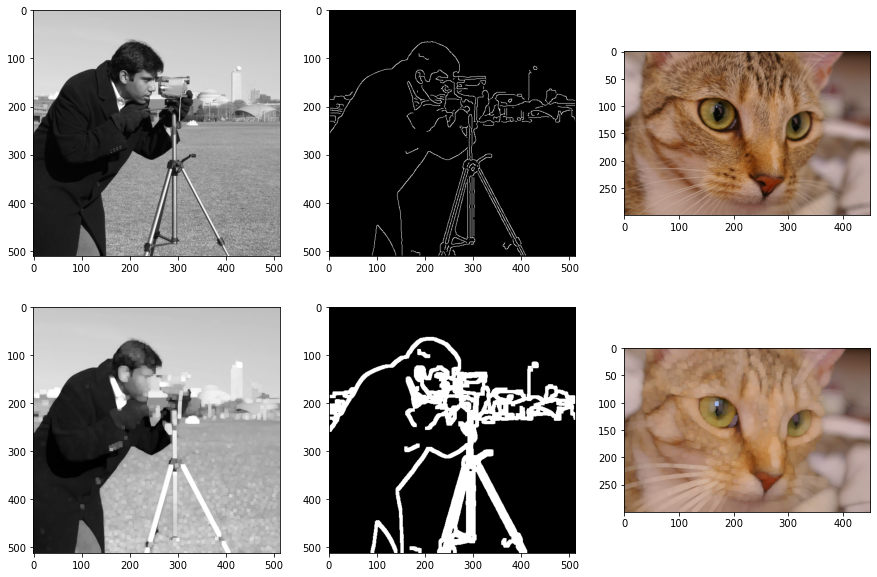

In [137]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_dilatacion(img_gray, se), 'gray')
axes[1,1].imshow(im_dilatacion(img_bin, se), 'gray')
axes[1,2].imshow(im_dilatacion(img_rgb, se))

# Operaciones morfológicas
Implementar funciones que devuelvan los siguientes structuring elements. Son similares a un kernel convolucional pero el tipo de dato es booleano (True o False). Incluso pueden construirse aplicando un threshold a un kernel. Ej: se_box = kernel_box > 0



# 1. Box
Operaciones básicas (nivel 1):
1. Dilatación

In [138]:
#Filtro Cuadrado
N=7
se = np.ones((N,N), dtype=bool)

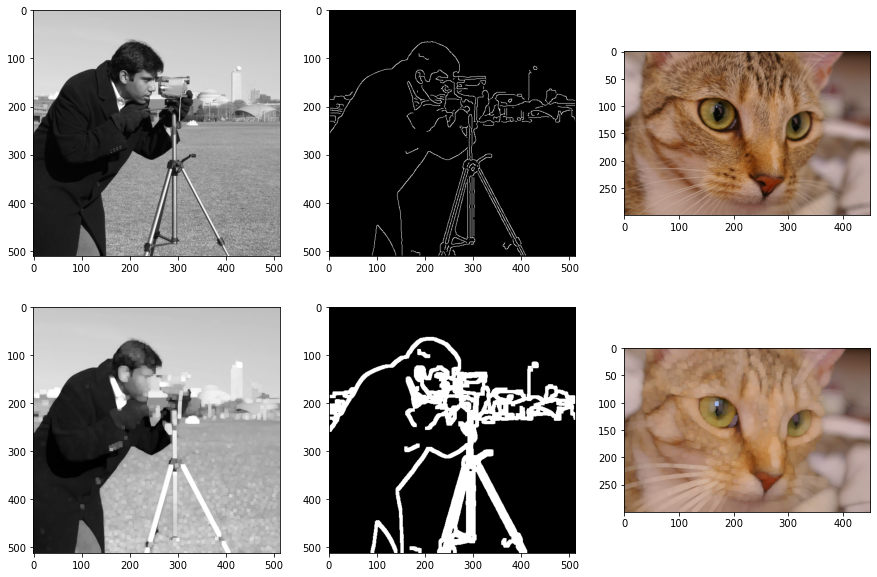

In [139]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_dilatacion(img_gray, se), 'gray')
axes[1,1].imshow(im_dilatacion(img_bin, se), 'gray')
axes[1,2].imshow(im_dilatacion(img_rgb, se))

### 2. Erosión

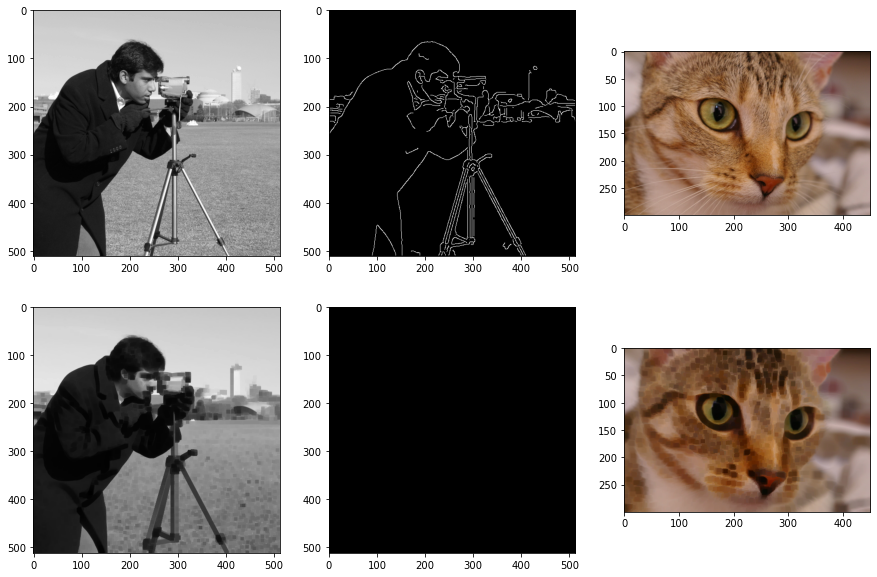

In [140]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_erosion(img_gray, se), 'gray')
axes[1,1].imshow(im_erosion(img_bin, se), 'gray')
axes[1,2].imshow(im_erosion(img_rgb, se))

### 3. Filtro de mediana

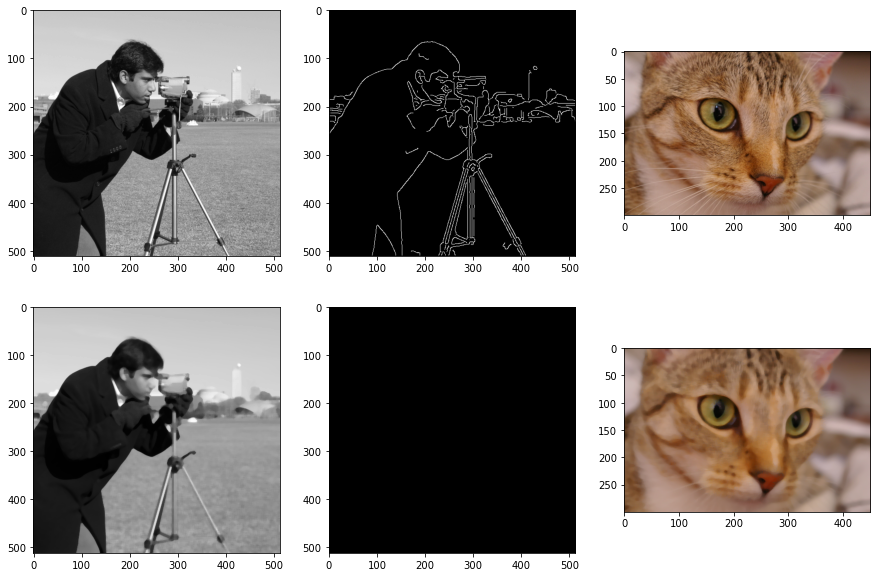

In [141]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_fmediana(img_gray, se), 'gray')
axes[1,1].imshow(im_fmediana(img_bin, se), 'gray')
axes[1,2].imshow(im_fmediana(img_rgb, se))

## Operaciones de suma/resta entre erosión y dilatación:
4. Borde externo

In [142]:
im_dilatacion_gray=im_dilatacion(img_gray, se)
im_dilatacion_bin=im_dilatacion(img_bin, se)
im_dilatacion_rgb=im_dilatacion(img_rgb, se)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


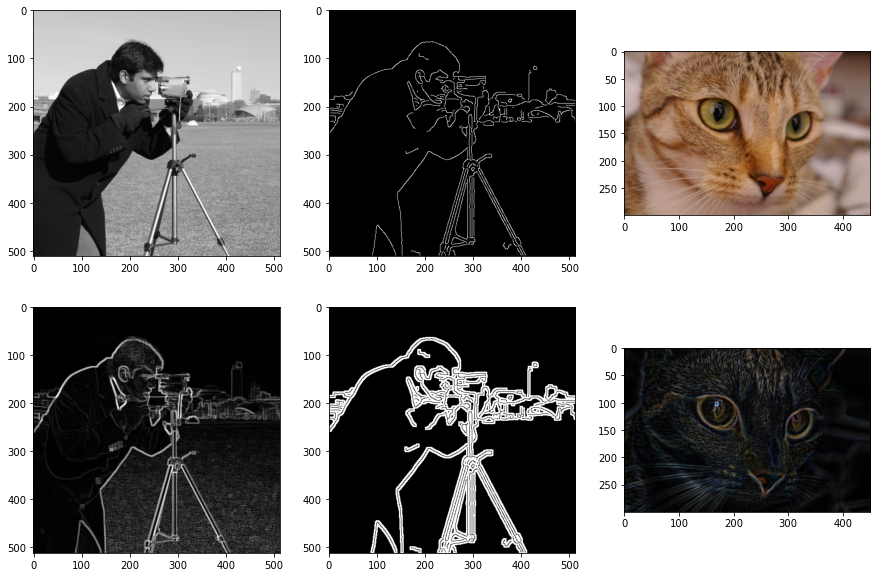

In [143]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_dilatacion_gray-img_gray, 'gray')
axes[1,1].imshow(im_dilatacion_bin-img_bin, 'gray')
axes[1,2].imshow(im_dilatacion_rgb-img_rgb)

### 5. Borde interno

In [144]:
im_erosion_gray=im_erosion(img_gray, se)
im_erosion_bin=im_erosion(img_bin, se)
im_erosion_rgb=im_erosion(img_rgb, se)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


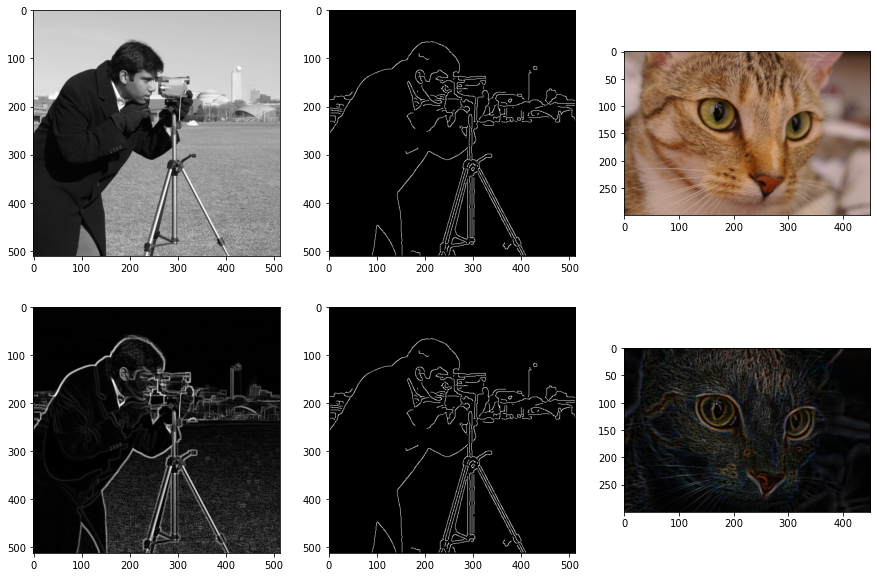

In [145]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_gray-im_erosion_gray, 'gray')
axes[1,1].imshow(img_bin-im_erosion_bin, 'gray')
axes[1,2].imshow(img_rgb-im_erosion_rgb)

### 6. Gradiente

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


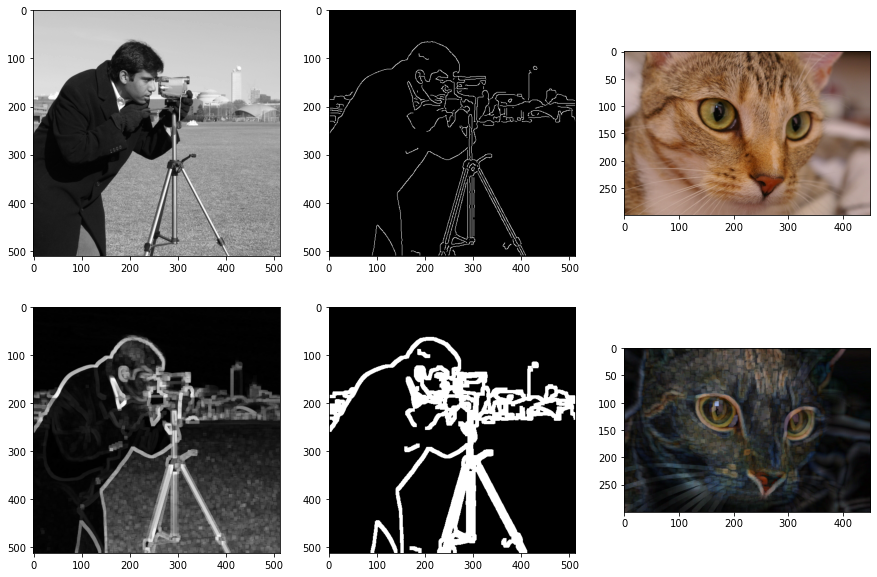

In [146]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_dilatacion_gray-im_erosion_gray , 'gray')
axes[1,1].imshow(im_dilatacion_bin-im_erosion_bin, 'gray')
axes[1,2].imshow(im_dilatacion_rgb-im_erosion_rgb)

### Operaciones concatenando dilatación y erosión (nivel 2):

7. Apertura (opening)

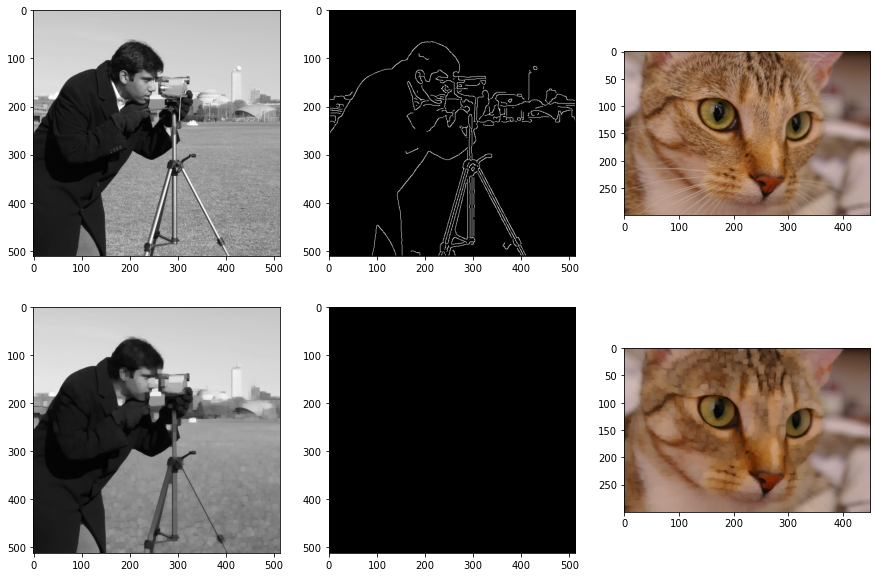

In [147]:
im_open_gray=im_dilatacion(im_erosion_gray, se)
im_open_bin=im_dilatacion(im_erosion_bin, se)
im_open_rgb=im_dilatacion(im_erosion_rgb, se)
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_open_gray, 'gray')
axes[1,1].imshow(im_open_bin, 'gray')
axes[1,2].imshow(im_open_rgb)

### 8. Cierre (closing)

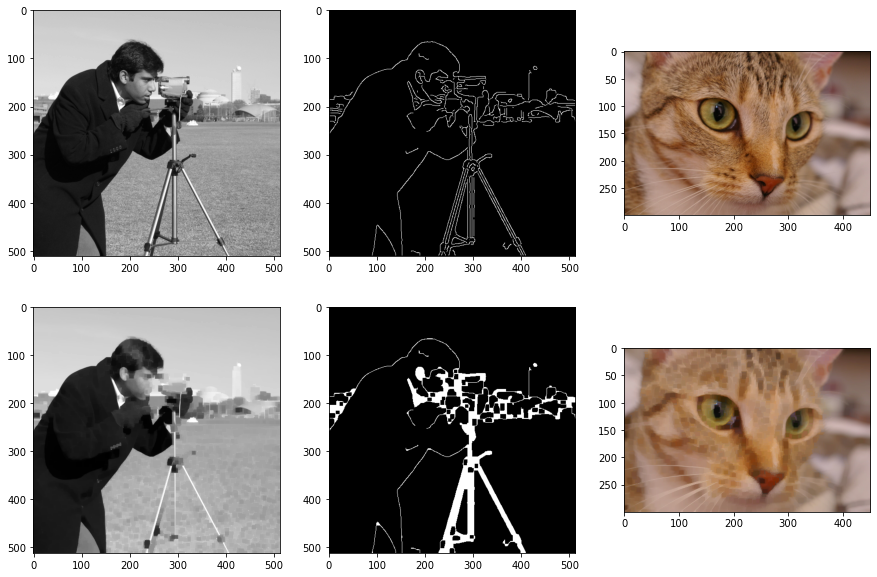

In [148]:
im_closed_gray=im_erosion(im_dilatacion_gray, se)
im_closed_bin=im_erosion(im_dilatacion_bin, se)
im_closed_rgb=im_erosion(im_dilatacion_rgb, se)
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_closed_gray, 'gray')
axes[1,1].imshow(im_closed_bin, 'gray')
axes[1,2].imshow(im_closed_rgb)

### 9. Top-hat(imagen menos apertura): , retiene los elementos de la figura que sean más pequeños que B y más brillantes que su entorno

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


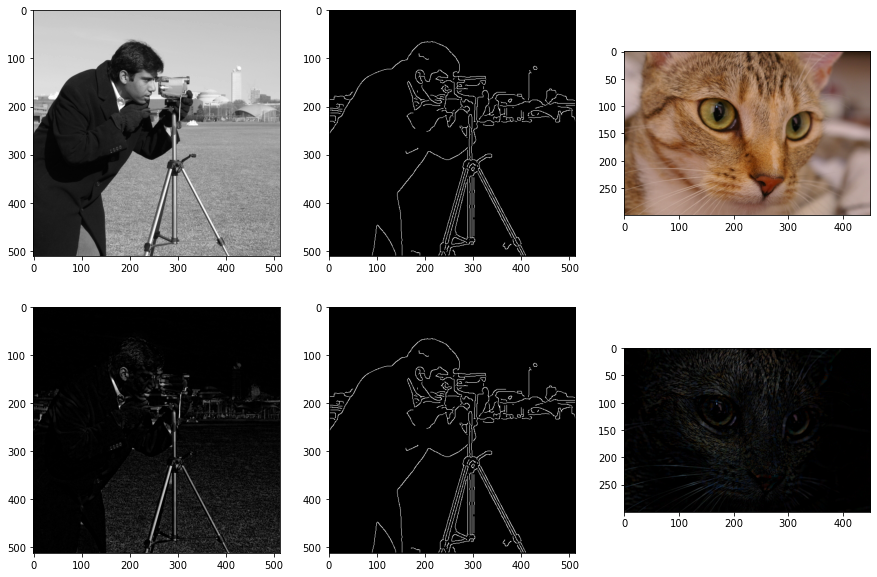

In [149]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_gray-im_open_gray, 'gray')
axes[1,1].imshow(img_bin-im_open_bin, 'gray')
axes[1,2].imshow(img_rgb-im_open_rgb)

### 10. Bottom-hat